# Recurrent Neural Network

## 1. Libraries
*Installing and importing necessary packages*

In [13]:
import sys
import os
!{sys.executable} -m pip install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!{sys.executable} -m pip install matplotlib

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from IPython.display import Markdown as md
from IPython.display import display, clear_output
import utils
import numpy as np
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## 2. Variables
*Indicate the root directory where the data must be downloaded, the directory where the results should be saved and the type of RNN (conventional, LSTM, GRU) and its respective hyper-parameters*

In [14]:
params = {'root': './data/',
          'results_dir': './results/',
          'model_type': 'RNN',
          'batch_size': 512,
          'epochs': 2,
          'save_step': 50,
          'lr': 0.001,
          'weight_decay': 1e-5,
          'num_classes': 10,
          'num_layers': 2,
          'hidden_size': 128,
          'input_size': 28,
          'sequence_length': 28}

device = torch.device('cpu') if torch.cuda.is_available() else torch.device('gpu')
utils.ensure_dir(params['results_dir'])

## 3. Dataset

In [15]:
mnist_train = datasets.MNIST(root=params['root'], train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root=params['root'], train=False, download=True, transform=transforms.ToTensor())
print("MNIST Train {}, Test {}".format(len(mnist_train), len(mnist_test)))

mnist_train_dataloader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=params['batch_size'], shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=params['batch_size'], shuffle=True)

MNIST Train 60000, Test 10000


## 4. The Model: RNN
$h_t = \sigma(W x_t + U h_{t-1})$

Some important information is: 
* Input size: number of expected features in input $x$
* Hidden size: number of features in hidden state $h$
* After forward propagation, output has shape (batch_size, seq_length, hidden_size)

In [16]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.input_size = params['input_size']
        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        self.model_type = params['model_type']
        
        if self.model_type == 'RNN':
            self.rnn = nn.RNN(self.input_size, self.hidden_size, num_layers=self.num_layers, bias=True, nonlinearity='tanh')
        elif self.model_type == 'GRU':
            self.rnn = nn.GRU(self.input_size, self.hidden_size, num_layers=self.num_layers, bias=True)
        else:  # 'LSTM'
            self.rnn = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, params['num_classes'])
        
    def forward(self, x):           
        # Set initial hidden state $h0$ and cell state $c0$
        h0 = torch.zeros(self.num_layers, self.input_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, self.input_size, self.hidden_size).to(device)

        # Forward propagate RNN
        if self.model_type == 'LSTM':
            out, hidden = self.rnn(x, (h0, c0)) 
        else:
            out, hidden = self.rnn(x, h0)
        
        # Decode last hidden state
        out = self.fc(out[:, -1, :])
        # print(out.shape)
        return out

## 5. Train

res_dir: ./results/LSTM_2layers_adam_lr0.001_weight1e-05_trainSize_60000_testSize_10000/


Completed 0.4237%: Epoch/step [1/2 - 1/118], loss 2.3049


Completed 21.6102%: Epoch/step [1/2 - 51/118], loss 2.2975


Completed 42.7966%: Epoch/step [1/2 - 101/118], loss 2.3012


Completed 50.4237%: Epoch/step [2/2 - 1/118], loss 2.3041


Completed 71.6102%: Epoch/step [2/2 - 51/118], loss 2.2722


Completed 92.7966%: Epoch/step [2/2 - 101/118], loss 2.2869


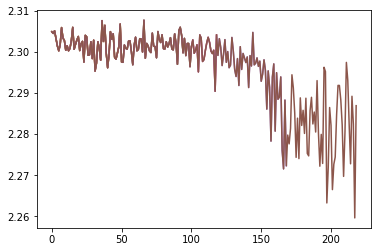

In [17]:
# Instantiate model
model = RNN()

# Loss criterion and optimizer
criterion = nn.CrossEntropyLoss()  # L1Loss, SmoothL1Loss, NLLLoss(), CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

# New results dir based on model's parameters
res_dir = params['results_dir'] + '{}_{}layers_adam_lr{}_weight{}_trainSize_{}_testSize_{}/'.\
    format(params['model_type'], params['num_layers'], params['lr'], params['weight_decay'], len(mnist_train), len(mnist_test))
utils.ensure_dir(res_dir)

print("res_dir: {}".format(res_dir))
log_file = open(res_dir + 'log.txt', 'w')
loss_arr = []
first_time = True
total_num_steps = len(mnist_train_dataloader)
for e in range(1, params['epochs']+1):
    for i, (img, label) in enumerate(mnist_train_dataloader):
        img = torch.squeeze(img).to(device)
        label = label.to(device)
        
        # Forward
        out = model(img)
        loss = criterion(out, label)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_arr.append(loss.item())
        
        if i % params['save_step'] == 0:
            # Print update
            perc = 100 * ((e-1)*total_num_steps + (i+1))/(params['epochs'] * total_num_steps)
            str_res = "Completed {:.4f}%: Epoch/step [{}/{} - {}/{}], loss {:.4f}\n".format(perc, e, params['epochs'], i+1, total_num_steps, loss.item())
            print("\r" + str_res, end="")
            # Save log
            log_file.write(str_res)
            # Save training loss
            plt.plot(loss_arr)
            plt.savefig(res_dir + 'loss.png')
            # Save model checkpoint
            torch.save(model.state_dict(), res_dir + 'model.ckpt')
plt.show()

## 6. Test

In [19]:
# Testing doesn't require the use of gradients since weights aren't being updated
with torch.no_grad():
    correct = 0
    total = 0
    
    for img, label in mnist_test_dataloader:
        img = torch.squeeze(img).to(device)
        label = label.to(device)
        
        # Forward
        out = model(img)
        
        # Test
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    print('Test Accuracy: {:.4f} %'.format(100 * correct / total)) 

Test Accuracy: 12.1300 %
